In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

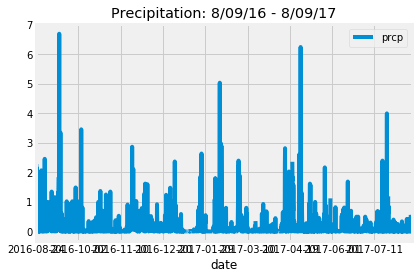

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latestDate = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())
latestDate = list(np.ravel(latestDate))[0]
latestDate = dt.datetime.strptime(latestDate, '%Y-%m-%d')
latestYear = int(dt.datetime.strftime(latestDate, '%Y'))
latestMonth = int(dt.datetime.strftime(latestDate, '%m'))
latestDay = int(dt.datetime.strftime(latestDate, '%d'))
# Calculate the date 1 year ago from the last data point in the database
yearBefore = dt.date(latestYear, latestMonth, latestDay) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rainData = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > yearBefore)
                  .order_by(Measurement.date)
                  .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
rainTable = pd.DataFrame(rainData)
rainTable = rainTable.set_index('date')

# Sort the dataframe by date
rainTable = rainTable.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
rainTable.plot(title="Precipitation: 8/09/16 - 8/09/17")

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rainTable.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
stationsCount = session.query(Station).count()
print(f"Station Count: {stationsCount}")

Station Count: 9


In [13]:
stationCounts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
stationCounts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?stationID = stationCounts[0][0]
stationID = stationCounts[0][0]
stationName = (session.query(Station.name)
                      .filter_by(station = stationID))
stationName = stationName[0][0]
print(f"The most active station is {stationID}: {stationName}.")
# List the stations and the counts in descending order.


The most active station is USC00519281: WAIHEE 837.5, HI US.


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
highestTemp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == stationID)
                      .order_by(Measurement.tobs.desc())
                      .first())
highestTemp = highestTemp[0]
print(f"The highest temperature recorded there is {highestTemp} degrees Farenheit.")
lowestTemp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == stationID)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowestTemp = lowestTemp[0]
print(f"The lowest temperature recorded there is {lowestTemp} degrees Farenheit.")
avgTemp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == stationID))
avgTemp = '{0:.3}'.format(avgTemp[0][0])
print(f"The average temperature recorded there is {avgTemp} degrees Farenheit.")

The highest temperature recorded there is 85.0 degrees Farenheit.
The lowest temperature recorded there is 54.0 degrees Farenheit.
The average temperature recorded there is 71.7 degrees Farenheit.


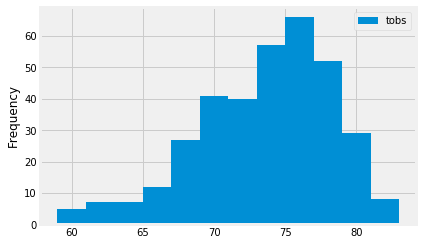

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempData = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > yearBefore)
                   .filter(Measurement.station == stationID)
                   .order_by(Measurement.date)
                   .all())

#convert query object to data frame
tempTable = pd.DataFrame(tempData)
tempTable = tempTable.set_index('date')

#sory by date
tempTable = tempTable.sort_index(ascending=True)

#histogram plot with pandas
tempTable.plot(kind='hist', bins=12)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
#set trip dates and previous dates
trip = '2019-04-08 to \n 2019-04-19'
tripStartDate = '2017-04-08'
tripEndDate = '2017-04-19'

#calculate the tmin, tavg, and tmax 
tripTemps = calc_temps(tripStartDate, tripEndDate)

tripTemps

[(67.0, 73.6, 83.0)]

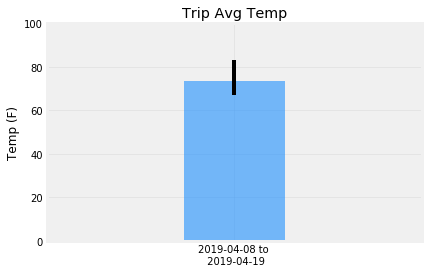

In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
minTripTemp = tripTemps[0][0]
avgTripTemp = tripTemps[0][1]
maxTripTemp = tripTemps[0][2]

minError = avgTripTemp - minTripTemp
maxError = maxTripTemp - avgTripTemp

errorBars = np.array([[minError], [maxError]])

plt.bar(trip, avgTripTemp, yerr=errorBars, color = 'dodgerblue', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)

In [20]:
#query for precipitation per station on trip dates
sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

stationRain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= tripStartDate)
                   .filter(Measurement.date <= tripEndDate)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

#convert query object to data frame
stationRainTable = pd.DataFrame(np.array(stationRain))
#rename columns
stationRainTable = stationRainTable.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

stationRainTable

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",7.38,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",6.979999999999999,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",2.48,21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.86,21.5213,-157.8374,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.8099999999999999,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.31000000000000005,21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9
